# Test the two-line CLEDB inversion on synthetic data.

In [1]:
## the script version "test_2line.py" is generated by exporting this notebook via file -> export as -> executable script.
## Do not directly edit that version!

In [1]:
## Inversion Constants and control parameter imports.
## symbolic links pointing to the root directory containing the files are used. Pythondoes not allow relative upstream references anymore
import constants as consts
import ctrlparams
params=ctrlparams.ctrlparams()    ##Initialize and use a shorter label

## Needed modules
import pickle                ## CLE synthetic observation data cube is saved in the pickle format.
import importlib             ## reloads imports (python default settings will not reload small changes).
import numpy as np           ## Defines variables to store/load headers

from numba.typed import List ## Most numba functions are loaded by the CLEDB modules; non-reflected lists are needed to create a list of 2 observation arrays



### 1. Import the synthetic CLE observation.

In [2]:
## observations of a 3 dipole coronal structure of a Fe XIII combined observation
## sobs1-3 are the independent dipoles
## sobsa is the combined 3 dipole output
## waveA and waveB are the wavelength arrays for the two Fe XIII lines

# with open('obsstokes_3dipole_hires_fullspectra.pkl','rb') as f:
#     sobs1,sobs2,sobs3,sobsa,waveA,waveB = pickle.load(f)  
# ### reversing of the wavelength range. THIS IS NEEDED! CLE writes frequency-wise, so wavelengths are reversed in the original datacubes!!!!!!
# sobsa=sobsa[:,:,::-1,:]

# ## A fake minimal header for CLE
# ## This assumes the reference pixel is in the left bottom of the array; the values are in solar coordinates at crpixn in r_sun. The wavelength raferences (vacuum), ranges and spectral resolutions are unique. See CLE outfiles and grid.dat.
# head_in =  [np.array((0, 0, np.int32(sobsa.shape[2]/2)-1,\
#                      -0.75, 0.8, 1074.62686-0.0124,\
#                      (0.75-(-0.75))/sobsa.shape[0], (1.5-0.8)/sobsa.shape[1], 0.0247,"CLE-SIM"),\
#                     dtype = [('crpix1', np.float32), ('crpix2', np.float32), ('crpix3', np.float32),\
#                               ('crval1', np.float32), ('crval2', np.float32),('crval3', np.float32),\
#                               ('cdelt1', np.float32), ('cdelt2', np.float32),('cdelt3', np.float32), ('instrume','U7')]).view(np.recarray),\
#             np.array((0, 0, np.int32(sobsa.shape[2]/2)-1,\
#                      -0.75, 0.8, 1079.78047-0.0124,\
#                      (0.75-(-0.75))/sobsa.shape[0], (1.5-0.8)/sobsa.shape[1], 0.0249,"CLE-SIM"),\
#                     dtype = [('crpix1', np.float32), ('crpix2', np.float32), ('crpix3', np.float32),\
#                               ('crval1', np.float32), ('crval2', np.float32),('crval3', np.float32),\
#                               ('cdelt1', np.float32), ('cdelt2', np.float32),('cdelt3', np.float32), ('instrume', 'U7')]).view(np.recarray)  ]

# 
#waveA=waveA[::-1]         ##the wave arrays are not needed by the inversion. the information is reconstructed from keywords
#waveB=waveB[::-1]

In [3]:
## observations of sheetlos coronal structure of a Fe XIII combined observation
## sobsa is the combined 5 dipole output
## waveA and waveB are the wavelength arrays for the two Fe XIII lines

# with open('obsstokes_sheetslos_hires_fullspectra.pkl','rb') as f:
#    sobsa,waveA,waveB = pickle.load(f)  
### reversing of the wavelength range. THIS IS NEEDED! CLE writes frequency-wise, so wavelengths are reversed in the original datacubes!!!!!!
# sobsa=sobsa[:,:,::-1,:]


# waveA=waveA[::-1]         ##the wave arrays are not needed by the inversion. the information is reconstructed from keywords
# waveB=waveB[::-1]

In [4]:
# load the fake observation muram data.             
# FE XIII 1074+1079

with open('obsstokes_avg_muram3.pkl','rb') as f:
    sobsa = pickle.load(f) 
sobsa=sobsa[0]  

# A fake minimal header for MURAM
# This assumes the reference pixel is in the left bottom of the array; the values are in solar coordinates at crpixn in r_sun (from muram xvec and yvec arrays). The wavelength raferences (vacuum), ranges and spectral resolutions are unique (muram wvvec1 and wvvce2 arrays).
head_in =  [np.array((0, 0, 0,\
                     -0.071, 0.989, 1074.257137,\
                     0.0001379,  0.0000689, 0.0071641,"MUR-SIM" ),\
                    dtype = [('crpix1', np.float32), ('crpix2', np.float32), ('crpix3', np.float32),\
                              ('crval1', np.float32), ('crval2', np.float32),('crval3', np.float32),\
                              ('cdelt1', np.float32), ('cdelt2', np.float32),('cdelt3', np.float32), ('instrume','U7')]).view(np.recarray),\
            np.array((0, 0, 0,\
                    -0.071, 0.989, 1079.420513,\
                     0.0001379,  0.0000689, 0.0071985,"MUR-SIM" ),\
                    dtype = [('crpix1', np.float32), ('crpix2', np.float32), ('crpix3', np.float32),\
                              ('crval1', np.float32), ('crval2', np.float32),('crval3', np.float32),\
                              ('cdelt1', np.float32), ('cdelt2', np.float32),('cdelt3', np.float32), ('instrume','U7')]).view(np.recarray)  ]

## muram data too big to include as test data!!!!

### 2. Test the CLEDB_PREPINV module with synthetic data. 

##### Remember to set your personal options and database paths in the ctrlparams class (in the parent directory) before continuing.

In [5]:
import CLEDB_PREPINV.CLEDB_PREPINV as prepinv  ##imports from the CLEDB_PREPINV subdirectory

In [6]:
## arrange the two observation "files" in a simple list;
## un-necesary step given the shape of sobs array, but it mimicks a file/header structure.

## set a proper numba typed list
sobs_lst=[sobsa[:,:,:,0:4],sobsa[:,:,:,4:8]]  ## standard python lists will be deprecated ; they do not work well with numba
sobs_in = List()                              ## this is the List object implemented by numba; It utilizes memory in a column-like fashion.
[sobs_in.append(x) for x in sobs_lst]         ## Numba developers claim that it is a significantly faster performing object

[None, None]

##### preprocess the observation "files"

In [7]:
importlib.reload(prepinv)       ## If module is modified, reload the contents
sobs_tot,yobs,rms,background,keyvals,sobs_totrot,aobs=prepinv.sobs_preprocess(sobs_in,head_in,params)

------------------------------------
--------OBS PROCESSING START--------
------------------------------------
We are inverting observations of 2 coronal line(s) 
Line 1: Fe XIII 1074.7nm
Line 2: Fe XIII 1079.8nm
------------------------------------
-----OBS PREPROCESS FINALIZED-------
------------------------------------


In [8]:
## select and pre-read the database files based on the observation preprocessing
## At this point, the database should be generated and properly linked.
importlib.reload(prepinv)       ## If module is modified, reload the contents
db_enc,database,dbhdr=prepinv.sdb_preprocess(yobs,keyvals,params)
## Warning, this might be memory consuming; see details in documentation

------------------------------------
----------DB READ START-------------
------------------------------------
CLEDB covers a span of 51 heights between 1.0 - 1.5 Solar radius
Load DB datafiles for 7  heights in memory for 2 line(s).
------------------------------------
INDIVIDUAL DB file location: /home/noxpara/Documents/physics_prog/cle/db204_R0500/fe-xiii_1074/DB0000.DAT
INDIVIDUAL DB file location: /home/noxpara/Documents/physics_prog/cle/db204_R0500/fe-xiii_1079/DB0000.DAT
INDIVIDUAL DB file location: /home/noxpara/Documents/physics_prog/cle/db204_R0500/fe-xiii_1074/DB0060.DAT
INDIVIDUAL DB file location: /home/noxpara/Documents/physics_prog/cle/db204_R0500/fe-xiii_1079/DB0060.DAT
INDIVIDUAL DB file location: /home/noxpara/Documents/physics_prog/cle/db204_R0500/fe-xiii_1074/DB0050.DAT
INDIVIDUAL DB file location: /home/noxpara/Documents/physics_prog/cle/db204_R0500/fe-xiii_1079/DB0050.DAT
INDIVIDUAL DB file location: /home/noxpara/Documents/physics_prog/cle/db204_R0500/fe-xiii_107

##### At this point all necesary data and required databases are loaded into memory for fast processing

### 3. Test the CLEDB_PROC module with the same synthetic data.

In [9]:
import CLEDB_PROC.CLEDB_PROC as procinv

In [10]:
aa=np.array([2,5,1,7,5,9,1,6,4])
np.argwhere((aa == np.min(aa)) | (aa==np.max(aa)))

array([[2],
       [5],
       [6]])

##### Process the spectroscopy outputs

In [14]:
importlib.reload(procinv)       ## If module is modified, reload the contents 
specout=procinv.spectro_proc(sobs_in,sobs_tot,rms,background,keyvals,consts,params)      ## when storing to disk do an if to reduce dimensions for 1 line cases

--------------------------------------
SPECTRO_PROC: SPECTROSCOPY START
--------------------------------------
SPECTRO_PROC: Executing ext. loop: 600  of  1024  ( 1024  calculations / loop)
0.000063  bkg
0.345237  cfd
0.345623  ps1
0.345763  for
0.345828  ps2
0.411799  gf
0.411835  iqu
0.411883  v
0.411912  fin
0.000029  bkg
0.000154  cfd
0.000248  ps1
0.000374  for
0.000430  ps2
0.000640  gf
0.000659  iqu
0.000690  v
0.000713  fin
0.000021  bkg
0.000128  cfd
0.000196  ps1
0.000326  for
0.000379  ps2
0.000557  gf
0.000575  iqu
0.000606  v
0.000628  fin
0.000020  bkg
0.000125  cfd
0.000192  ps1
0.000319  for
0.000371  ps2
0.000546  gf
0.000564  iqu
0.000595  v
0.000617  fin
0.000020  bkg
0.000112  cfd
0.000177  ps1
0.000317  for
0.000369  ps2
0.000542  gf
0.000559  iqu
0.000589  v
0.000611  fin
0.000020  bkg
0.000149  cfd
0.000215  ps1
0.000340  for
0.000391  ps2
0.000563  gf
0.000580  iqu
0.000610  v
0.000631  fin
0.000019  bkg
0.000102  cfd
0.000166  ps1
0.000298  for
0.000350  ps2
0.

KeyboardInterrupt: 

##### Process the LOS magnetic fields from the first line

In [15]:
importlib.reload(procinv)       ## If module is modified, reload the contents 
blosout=procinv.blos_proc(sobs_tot,rms,keyvals,consts,params)

--------------------------------------
---BLOS_PROC: LOS B ESTIMATION START--
--------------------------------------
--------------------------------------
---BLOS_PROC: LOS B ESTIMATION END----
--------------------------------------


##### Process the full vector magnetic field inversion products

In [ ]:
importlib.reload(procinv)       ## If module is modified, reload the contents
sobs_dopp=np.zeros((600,280,3))
invout,sfound=procinv.cledb_invproc(sobs_totrot,sobs_dopp,database,db_enc,yobs,aobs,rms,dbhdr,keyvals,params.nsearch,params.maxchisq,params.bcalc,params.iqud,params.reduced,params.verbose)
## WARNING: This step has a significantly long execution time.

## All should be good if we reached this point; all the outputs should be computed and saved in memory.

## 4. OPTIONAL tidbits

In [16]:
##optionally needed libraries and functions

from datetime import datetime
import os
import glob
import numpy as np

from matplotlib import pyplot as plt
## interactive plotting; use only on local machines if widget is installed
##%matplotlib widget       

# colorbar function to have nice colorbars in figures with title
def colorbar(mappable,*args,**kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax,format='%.2f')
    #cbar.formatter.set_powerlimits((0, 0))
    title= kwargs.get('title', None)
    cbar.set_label(title)
    plt.sca(last_axes)
    return cbar



### 4.a DUMP results (optional)

In [17]:

## Remove old file saves and keep just the last run
lst=glob.glob('./outparams_2line*.pkl')
if len(lst) >0:
    for i in range(len(lst)):
        os.remove(lst[i])
        
## save the last run 
datestamp = datetime.now().strftime("%Y%m%d-%H:%M:%S")        

# if not os.path.exists('./testrun_outputs'):               ## make an output directory to keep things clean
#     os.makedirs('./testrun_outputs')

# with open(f'./testrun_outputs/outparams_2line_{datestamp}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([specout,blosout,invout,sfound], f)

### 4.b PLOT the outputs (optional)

In [18]:
## Plot utils

linen=0               ## choose which line to plot; range is [0:1] for 2 line input

## plot subranges for soome in snapshots
# ## 3dipole
# srx1=230
# srx2=400
# sry1=65
# sry2=195
# rnge=[0.8,1.5,-1.1,1.1]

#muram      ## muram data not offered as part of the test scripts due to large sizes.
srx1=0
srx2=1023
sry1=0
sry2=1023
rnge=[0.989,1.060,-0.071,0.071]


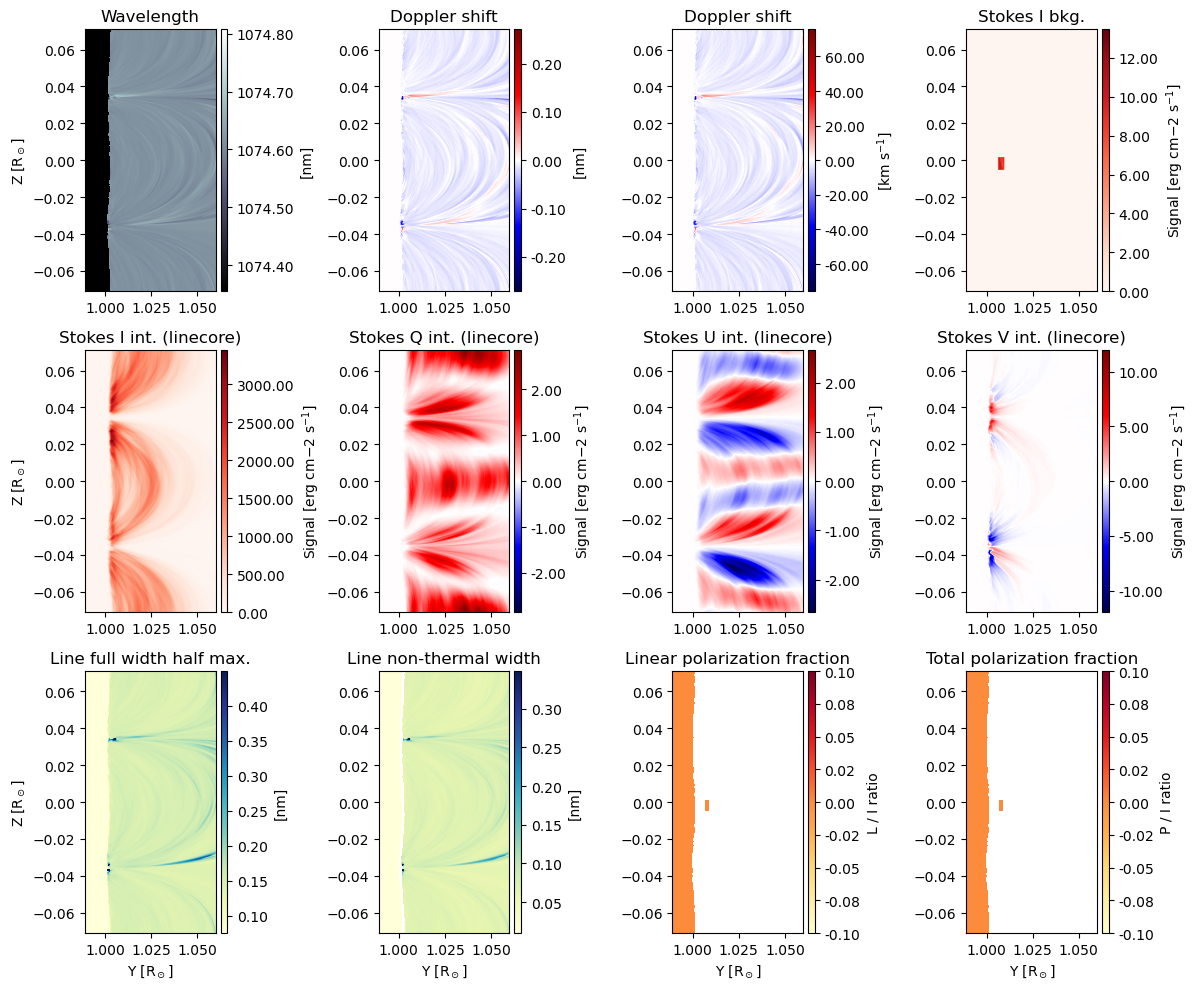

In [23]:
##Plot spectroscopy

fig, plots = plt.subplots(nrows=3, ncols=4, figsize=(12,10))

## remove the 0 values and unreasonable/outlier values.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,0], mask=specout[srx1:srx2,sry1:sry2,linen,0]==0)
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,0]>= 3950)
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,0]<= 1070)
vvmin=np.min(mx)
vvmax=np.max(mx)
ab=plots[0,0].imshow(specout[srx1:srx2,sry1:sry2,linen,0],extent=rnge,vmin=vvmin,vmax=vvmax,cmap='bone')
plots[0,0].set_title('Wavelength')
colorbar(ab,title="[nm]")
plots[0,0].set_ylabel('Z [R$_\odot$]')
#plots[0,0].set_xlabel('Y [R$_\odot$]')
############################################################

## for correctly scaling in doppler scales
## remove unreasonable/outlier values.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,1], mask=specout[srx1:srx2,sry1:sry2,linen,1]>= 2 )
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,1]<= -2 )
vvmax=np.max(mx)
vvmin=np.min(mx)
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[0,1].imshow(specout[srx1:srx2,sry1:sry2,linen,1],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[0,1].set_title('Doppler shift')
colorbar(ab,title="[nm]")
#plots[0,1].set_ylabel('Z [R$_\odot$]')
#plots[0,1].set_xlabel('Y [R$_\odot$]')
############################################################

## for correctly scaling in doppler scales
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,2], mask=specout[srx1:srx2,sry1:sry2,linen,2]>= 1000 )
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,2]<= -1000 )
vvmax=np.max(mx)
vvmin=np.min(mx)
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
## back to plotting    
ab=plots[0,2].imshow(specout[srx1:srx2,sry1:sry2,linen,2],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[0,2].set_title('Doppler shift')
colorbar(ab,title="[km s$^{-1}$]")
#plots[0,2].set_ylabel('Z [R$_\odot$]')
#plots[0,2].set_xlabel('Y [R$_\odot$]')
############################################################


ab=plots[0,3].imshow(specout[srx1:srx2,sry1:sry2,linen,7],extent=rnge,vmin=0,vmax=np.max(specout[srx1:srx2,sry1:sry2,linen,7]),cmap='Reds')
plots[0,3].set_title('Stokes I bkg.')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
#plots[0,3].set_ylabel('Z [R$_\odot$]')
#plots[0,3].set_xlabel('Y [R$_\odot$]')
############################################################

ab=plots[1,0].imshow(specout[srx1:srx2,sry1:sry2,linen,3],extent=rnge,vmin=0,vmax=np.max(specout[srx1:srx2,sry1:sry2,linen,3]),cmap='Reds')
plots[1,0].set_title('Stokes I int. (linecore)')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
plots[1,0].set_ylabel('Z [R$_\odot$]')
#plots[1,0].set_xlabel('Y [R$_\odot$]')
############################################################

vvmin=np.min(specout[srx1:srx2,sry1:sry2,linen,4])
vvmax=np.max(specout[srx1:srx2,sry1:sry2,linen,4])
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[1,1].imshow(specout[srx1:srx2,sry1:sry2,linen,4],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[1,1].set_title('Stokes Q int. (linecore)')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
#plots[1,1].set_ylabel('Z [R$_\odot$]')
#plots[1,1].set_xlabel('Y [R$_\odot$]')
############################################################

vvmin=np.min(specout[srx1:srx2,sry1:sry2,linen,5])
vvmax=np.max(specout[srx1:srx2,sry1:sry2,linen,5])
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[1,2].imshow(specout[srx1:srx2,sry1:sry2,linen,5],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[1,2].set_title('Stokes U int. (linecore)')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
#plots[1,2].set_ylabel('Z [R$_\odot$]')
#plots[1,2].set_xlabel('Y [R$_\odot$]')
############################################################

vvmin=np.min(specout[srx1:srx2,sry1:sry2,linen,6])
vvmax=np.max(specout[srx1:srx2,sry1:sry2,linen,6])
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[1,3].imshow(specout[srx1:srx2,sry1:sry2,linen,6],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[1,3].set_title('Stokes V int. (linecore)')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
#plots[1,3].set_ylabel('Z [R$_\odot$]')
#plots[1,3].set_xlabel('Y [R$_\odot$]')
############################################################


## remove unreasonable/outlier values.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,8], mask=specout[srx1:srx2,sry1:sry2,linen,8]>= 0.45 )
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,8]<= 0.01 )
vvmax=np.max(mx)
vvmin=np.min(mx)

ab=plots[2,0].imshow(specout[srx1:srx2,sry1:sry2,linen,8],extent=rnge,vmin=vvmin,vmax=vvmax,cmap='YlGnBu')
plots[2,0].set_title('Line full width half max.')
colorbar(ab,title="[nm]")
plots[2,0].set_ylabel('Z [R$_\odot$]')
plots[2,0].set_xlabel('Y [R$_\odot$]')
############################################################

## remove unreasonable/outlier values.
## PLOT INSIDE THE SAME SUBRANGES AS FULL WIDTHS TO SHOW THAT THEY ARE FRACTIONS.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,9], mask=specout[srx1:srx2,sry1:sry2,linen,9]>= 0.35 )
vvmax=np.nanmax(mx)
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,9]<= 0.01 )
vvmin=np.nanmin(mx)

ab=plots[2,1].imshow(specout[srx1:srx2,sry1:sry2,linen,9],extent=rnge,vmin=vvmin,vmax=vvmax,cmap='YlGnBu')
plots[2,1].set_title('Line non-thermal width')
colorbar(ab,title="[nm]")
#plots[2,1].set_ylabel('Z [R$_\odot$]')
plots[2,1].set_xlabel('Y [R$_\odot$]')
############################################################


ab=plots[2,2].imshow(specout[srx1:srx2,sry1:sry2,linen,10],extent=rnge,vmin=0.0,vmax=0.8*np.max(specout[srx1:srx2,sry1:sry2,linen,10]),cmap='YlOrRd')
plots[2,2].set_title('Linear polarization fraction')
colorbar(ab,title="L / I ratio")
#plots[0,0].set_ylabel('Z [R$_\odot$]')
plots[2,2].set_xlabel('Y [R$_\odot$]')
############################################################


ab=plots[2,3].imshow(specout[srx1:srx2,sry1:sry2,linen,11],extent=rnge,vmin=0.0,vmax=0.8*np.max(specout[srx1:srx2,sry1:sry2,linen,11]),cmap='YlOrRd')
plots[2,3].set_title('Total polarization fraction')
colorbar(ab,title="P / I ratio")
#plots[2,3].set_ylabel('Z [R$_\odot$]')
plots[2,3].set_xlabel('Y [R$_\odot$]')
############################################################

plt.tight_layout()

### Save the putput plots
if not os.path.exists('./testrun_outputs'):               ## make an output directory to keep things clean
    os.makedirs('./testrun_outputs')
plt.savefig(f"./testrun_outputs/specout_1line_line{linen}_{datestamp}.pdf")

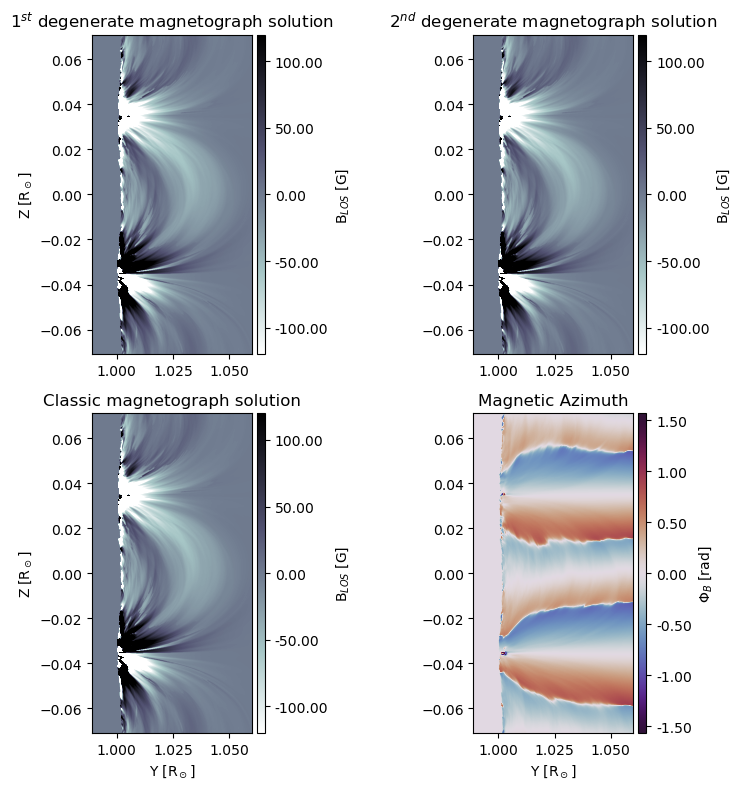

In [19]:
## plot 1-line BLOS
linen=1

fig, plots = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
ab=plots[0,0].imshow(blosout[srx1:srx2,sry1:sry2,0,linen],extent=rnge,cmap='bone_r',vmin=-120,vmax=120)
plots[0,0].set_title('1$^{st}$ degenerate magnetograph solution')
colorbar(ab,title="B$_{LOS}$ [G]")
plots[0,0].set_ylabel('Z [R$_\odot$]')
#plots[0,0].set_xlabel('Y [R$_\odot$]')

ab=plots[0,1].imshow(blosout[srx1:srx2,sry1:sry2,1,linen],extent=rnge,cmap='bone_r',vmin=-120,vmax=120)
plots[0,1].set_title('2$^{nd}$ degenerate magnetograph solution')
colorbar(ab,title="B$_{LOS}$ [G]")
#plots[0,1].set_ylabel('Z [R$_\odot$]')
#plots[0,1].set_xlabel('Y [R$_\odot$]')

ab=plots[1,0].imshow(blosout[srx1:srx2,sry1:sry2,2,linen],extent=rnge,cmap='bone_r',vmin=-120,vmax=120)
plots[1,0].set_title('Classic magnetograph solution')
colorbar(ab,title="B$_{LOS}$ [G]")
plots[1,0].set_ylabel('Z [R$_\odot$]')
plots[1,0].set_xlabel('Y [R$_\odot$]')

ab=plots[1,1].imshow(blosout[srx1:srx2,sry1:sry2,3,linen],extent=rnge,cmap='twilight_shifted')
plots[1,1].set_title('Magnetic Azimuth')
colorbar(ab,title="$\Phi_B$ [rad]")
plots[1,1].set_xlabel('Y [R$_\odot$]')

plt.tight_layout()

### Save the putput plots
if not os.path.exists('./testrun_outputs'):              ## make an output directory to keep things clean
    os.makedirs('./testrun_outputs')
plt.savefig(f"./testrun_outputs/blosout_1line_{datestamp}.pdf")

0.0 0.0


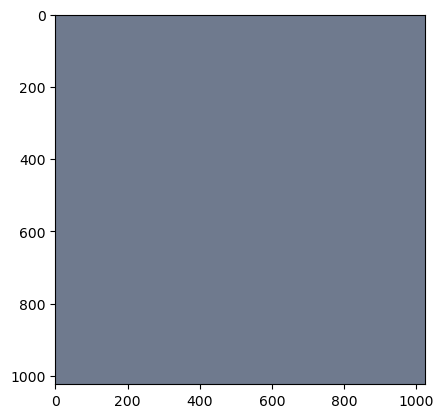

In [19]:
plt.figure()
#plt.imshow(blosout[srx1:srx2,sry1:sry2,0,linen]-blosout[srx1:srx2,sry1:sry2,1,linen],cmap='bone_r',vmin=-1,vmax=1)
plt.imshow(sobs_tot[:,:,3],cmap='bone_r',vmin=-100,vmax=100)
print(np.min(sobs_tot[:,:,3]),np.max(sobs_tot[:,:,3]))

(200.0, 300.0)

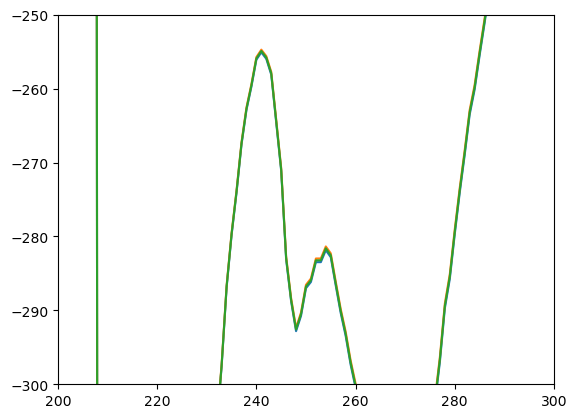

In [24]:
plt.figure()
plt.plot(blosout[800,sry1:sry2,0,0])
plt.plot(blosout[800,sry1:sry2,1,0])
plt.plot(blosout[800,sry1:sry2,2,0])
plt.ylim(-300,-250)
plt.xlim(200,300)

(array([8.000000e+00, 2.000000e+01, 2.700000e+01, 5.300000e+01,
        1.140000e+02, 2.450000e+02, 6.340000e+02, 1.405000e+03,
        3.608000e+03, 1.040415e+06]),
 array([-7588.08935547, -6829.28027344, -6070.47167969, -5311.66259766,
        -4552.85351562, -3794.04467773, -3035.23583984, -2276.42675781,
        -1517.61791992,  -758.80895996,     0.        ]),
 <BarContainer object of 10 artists>)

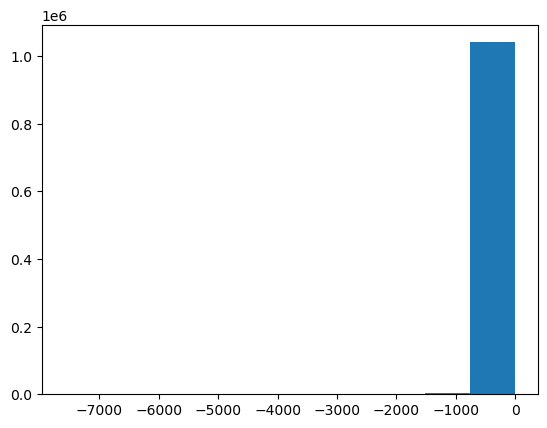

In [30]:
plt.figure()
plt.hist(blosout[srx1:srx2,sry1:sry2,0,0].flatten())

/tmp/ipykernel_1695812/4044492261.py:7: RuntimeWarning: invalid value encountered in log10
  ab=plots[0,0].imshow(np.log10(invout[srx1:srx2,sry1:sry2,soln,0]),extent=rnge,cmap='Set1')#,vmin=1e6,vmax=11e6)


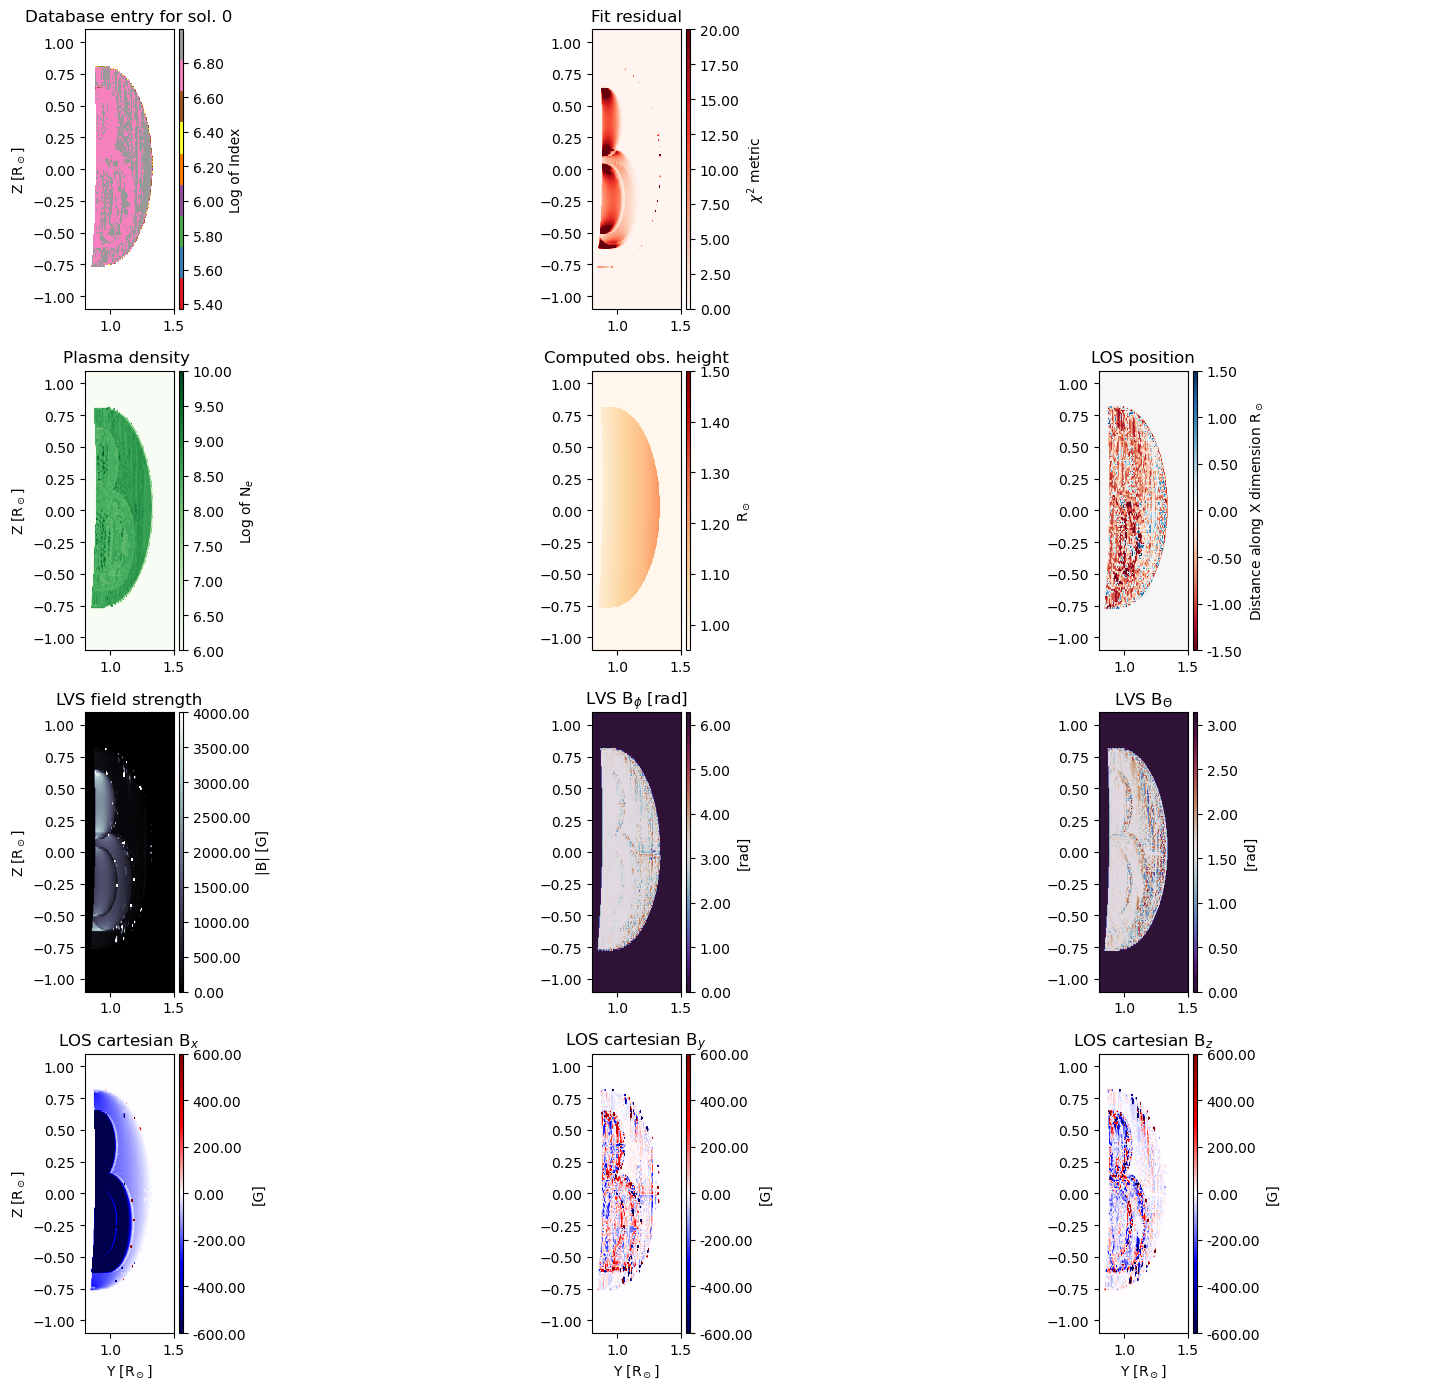

In [23]:
## Plot magnetic inversion

soln=0    ## selects the solution to plot < nsearch

fig, plots = plt.subplots(nrows=4, ncols=3, figsize=(16,14))

ab=plots[0,0].imshow(np.log10(invout[srx1:srx2,sry1:sry2,soln,0]),extent=rnge,cmap='Set1')#,vmin=1e6,vmax=11e6)
plots[0,0].set_title(f'Database entry for sol. {soln}')
colorbar(ab, title='Log of Index')
plots[0,0].set_ylabel('Z [R$_\odot$]')

ab=plots[0,1].imshow(invout[srx1:srx2,sry1:sry2,soln,1],extent=rnge,cmap='Reds',vmin=0,vmax=20)
plots[0,1].set_title('Fit residual')
colorbar(ab, title='$\chi^2$ metric')

plots[0, 2].axis('off') ###leave one empty panel

ab=plots[1,0].imshow(invout[srx1:srx2,sry1:sry2,soln,2],cmap='Greens',extent=rnge,vmin=6,vmax=10)
plots[1,0].set_title('Plasma density ')
colorbar(ab, title='Log of N$_e$')
plots[1,0].set_ylabel('Z [R$_\odot$]')

ab=plots[1,1].imshow(invout[srx1:srx2,sry1:sry2,soln,3],extent=rnge,cmap='OrRd',vmin=0.95,vmax=1.5)
plots[1,1].set_title('Computed obs. height')
colorbar(ab, title='R$_\odot$')

ab=plots[1,2].imshow(invout[srx1:srx2,sry1:sry2,soln,4],extent=rnge,cmap='RdBu',vmin=-1.5,vmax=1.5)
plots[1,2].set_title('LOS position')
colorbar(ab, title='Distance along X dimension R$_\odot$')


ab=plots[2,0].imshow(invout[srx1:srx2,sry1:sry2,soln,5],extent=rnge,cmap='bone',vmin=0,vmax=4000)
plots[2,0].set_title('LVS field strength')
colorbar(ab, title='|B| [G]')
plots[2,0].set_ylabel('Z [R$_\odot$]')

ab=plots[2,1].imshow(invout[srx1:srx2,sry1:sry2,soln,6],extent=rnge,vmin=0,vmax=6.28,cmap='twilight_shifted')
plots[2,1].set_title('LVS B$_\phi$ [rad]')
colorbar(ab, title='[rad]')

ab=plots[2,2].imshow(invout[srx1:srx2,sry1:sry2,soln,7],extent=rnge,vmin=0,vmax=3.14,cmap='twilight_shifted')
plots[2,2].set_title('LVS B$_\Theta$')
colorbar(ab, title='[rad]')


ab=plots[3,0].imshow(invout[srx1:srx2,sry1:sry2,soln,8],extent=rnge,cmap='seismic',vmin=-600,vmax=600)
plots[3,0].set_title('LOS cartesian B$_x$')
colorbar(ab, title='[G]')
plots[3,0].set_ylabel('Z [R$_\odot$]')
plots[3,0].set_xlabel('Y [R$_\odot$]')

ab=plots[3,1].imshow(invout[srx1:srx2,sry1:sry2,soln,9],extent=rnge,cmap='seismic',vmin=-600,vmax=600)
plots[3,1].set_title('LOS cartesian B$_y$')
colorbar(ab, title='[G]')
plots[3,1].set_xlabel('Y [R$_\odot$]')

ab=plots[3,2].imshow(invout[srx1:srx2,sry1:sry2,soln,10],extent=rnge,cmap='seismic',vmin=-600,vmax=600)
plots[3,2].set_title('LOS cartesian B$_z$')
colorbar(ab, title='[G]')
plots[3,2].set_xlabel('Y [R$_\odot$]')

plt.tight_layout()

### Save the putput plots
if not os.path.exists('./testrun_outputs'):              ## make an output directory to keep things clean
    os.makedirs('./testrun_outputs')
plt.savefig(f"./testrun_outputs/invout_2line__sol{soln}_{datestamp}.pdf")

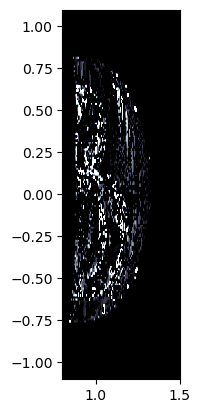

In [73]:
plt.figure()
plt.imshow(invout[srx1:srx2,sry1:sry2,0,5]*np.cos(invout[srx1:srx2,sry1:sry2,0,7]),extent=rnge,cmap='bone',vmin=0,vmax=200)

In [24]:
##Print inversion solution in a human readable way

np.set_printoptions(linewidth=200,suppress=False)   ## Suppress can be set to true to disable exponential notation.
xx=301      ## x pixel position
yy=105      ## y pixel positions


print("||    DB Index   ||     chi^2    ||  ne density  ||  y (height)  || x (LOS pos.) ||      B       ||    B_theta   ||    B_phi     ||      Bx      ||      By      ||     Bz       ||")
print(invout[xx,yy,:,:])


||    DB Index   ||     chi^2    ||  ne density  ||  y (height)  || x (LOS pos.) ||      B       ||    B_theta   ||    B_phi     ||      Bx      ||      By      ||     Bz       ||
[[ 5.9994750e+06  1.1444658e-02  7.9677339e+00  1.0625030e+00 -1.3000000e+00  4.5236990e+02  2.1060956e+00  2.6474099e+00 -1.0944909e+02  1.8455048e+02 -3.9824689e+02]
 [ 6.8472150e+06  1.1444658e-02  7.9677339e+00  1.0625030e+00  1.3000000e+00  4.5237006e+02  4.2121911e+00  5.2948195e-01 -1.0958166e+02 -2.0049358e+02  3.9042648e+02]
 [ 6.8391750e+06  1.1531248e-02  7.9677339e+00  1.0625030e+00  1.3000000e+00 -4.5339658e+02  1.0530478e+00  2.6474099e+00  1.0643442e+02  1.8686601e+02 -3.9915073e+02]
 [ 6.0075150e+06  1.1531252e-02  7.9677339e+00  1.0625030e+00 -1.3000000e+00 -4.5339630e+02  5.2652388e+00  5.2948195e-01  1.2025348e+02 -1.9488985e+02  3.9131223e+02]
 [ 6.8473050e+06  1.2058016e-02  7.9677339e+00  1.0625030e+00  1.3000000e+00  4.8249356e+02  4.2472925e+00  5.2948195e-01 -1.0930204e+02 -2.1781456e